# analysis – Statistical Exploration of Straight-Run Data (Excluding SenseBoard Loadcells)

This notebook investigates performance drivers in `all_data.csv` using only navigation and onboard sensor signals (**SenseBoard loadcell data are not used here**).  
The central question: **which variables explain differences in boat speed (SOG)?**

## Workflow

1. **Data preparation**
   - Load `all_data.csv`.
   - Remove non-informative fields (`drop_cols`), including identifiers, timestamps, coordinates, and loadcell-derived variables.
   - Keep only numeric features and drop rows without `SOG`.
   - Apply a missing-data filter: any variable with more than 20% NaN is excluded.

2. **Global analysis**
   - Apply `full_analysis(...)`, which:
     - Cleans the dataset according to missing-data threshold.
     - Computes correlations of all variables with **SOG**.
     - Runs **ANOVA** (via OLS regression) to quantify effect sizes of each predictor.
     - Fits a **linear regression model** to estimate coefficients and rank key contributors to speed.

3. **Upwind analysis (TWA ≥ 0)**
   - **All upwind runs**: overall feature importance with respect to SOG.
   - **Rider split**:
     - Gian’s upwind runs (including SenseBoard rows paired against Karl).
     - Karl’s upwind runs (including SenseBoard rows paired against Gian).
     - Compare Gian vs. Karl using an independent-samples **t-test** on SOG distributions.
   - **Role split**:
     - Master vs. Slave roles analyzed separately.
     - Master vs. Slave compared with a **t-test**.

4. **Downwind analysis (TWA < 0)**
   - **All downwind runs**: overall feature importance with respect to SOG.
   - **Rider split**:
     - Gian vs. Karl subsets, each analyzed independently.
     - SOG performance compared with a **t-test**.
   - **Role split**:
     - Master vs. Slave roles analyzed separately.
     - Compared with a **t-test**.

In [1]:

from analysis import *

drop_cols = [
    "TWD","COG","TWA", "TimeUTC", "SecondsSince1970", "ISODateTimeUTC","Latitude","Longitude","Euler_X (deg)","Euler_Y (deg)",
    "Lat", "LatBow", "LatCenter", "LatStern", "Lon", "LonBow", "LonCenter", "LonStern",
    "Leg", "Log", "LogAlongCourse", "MagneticVariation", "Rank", "TimeLocal",
    "DistanceToLeader", "interval_id", "boat_name", "interval_duration",
    "Heel", "Heel_Lwd", "Line_R", "Line_L", "BelowLineCalc", "VMC","XTE","VMG","gain_forward","gain_lateral", "gain_vmg","Total_lines", "LoadCell_1","LoadCell_2","LoadCell_3","LoadCell_4","LoadCell_5","LoadCell_6","M_tot_X","M_tot_Y","M_front_X","M_front_Y","M_back_X","M_back_Y","P_front_X","P_front_Y","P_back_X","P_back_Y","Side_lines","total_line2","Line_R2","Line_L2","Line_C"
]
df = pd.read_csv("all_data.csv")
MAX_NULL_RATIO = 0.2

## I. All together

In [2]:


df_numeric = df.select_dtypes(include=["float64", "int64"]).copy()
df_numeric.drop(columns=[c for c in drop_cols if c in df_numeric.columns], inplace=True)
df_numeric.dropna(subset=["SOG"], inplace=True)

print(f"Variables utilisées:", df_numeric.columns.tolist())
print(f"Number of rows after filtering: {len(df_numeric)}")


Variables utilisées: ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'SOG', 'boat_weight', 'Line_C2', 'side_line2']
Number of rows after filtering: 80131



Initial features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Selected features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Data cleaning:
- Initial samples: 80131
- Removed samples with NaNs: 2598
- Final samples: 77533

Correlation with SOG:


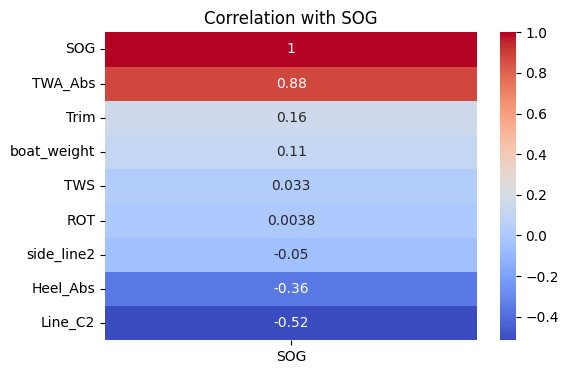


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
TWA_Abs,207881.923829,1.0,175773.155766,0.000000e+00,0.693941
boat_weight,5948.395975,1.0,5029.626016,0.000000e+00,0.060926
TWS,4419.633519,1.0,3736.991253,0.000000e+00,0.045988
Trim,1987.639731,1.0,1680.635342,0.000000e+00,0.021219
Line_C2,1179.336924,1.0,997.180366,1.781266e-217,0.012700
Heel_Abs,777.773896,1.0,657.641461,1.956141e-144,0.008412
ROT,66.634195,1.0,56.342093,6.154615e-14,0.000726
side_line2,62.460642,1.0,52.813174,3.702704e-13,0.000681
Residual,91685.435087,77524.0,NaN,NaN,0.500000



Polynomial fit:
R²: 0.803

Top coefficients:
    feature  coefficient
        TWS     0.180535
boat_weight     0.069565
    TWA_Abs     0.053106
       Trim    -0.052882
   Heel_Abs     0.017962
    Line_C2     0.011478
 side_line2     0.008904
        ROT     0.001569


,feature,coefficient
4,TWS,0.180535
5,boat_weight,0.069565
3,TWA_Abs,0.053106
2,Trim,-0.052882
0,Heel_Abs,0.017962
6,Line_C2,0.011478
7,side_line2,0.008904
1,ROT,0.001569


In [3]:
full_analysis(df_numeric, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

## II Upwind:

### II.1. All upwind data

In [4]:
upwind_data = df[df['TWA'] >= 0]
df_numeric_upwind = upwind_data.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_upwind.columns], inplace=True)
df_numeric_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_upwind)}")

Number of rows after filtering: 48787



Initial features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Selected features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Data cleaning:
- Initial samples: 48787
- Removed samples with NaNs: 1096
- Final samples: 47691

Correlation with SOG:


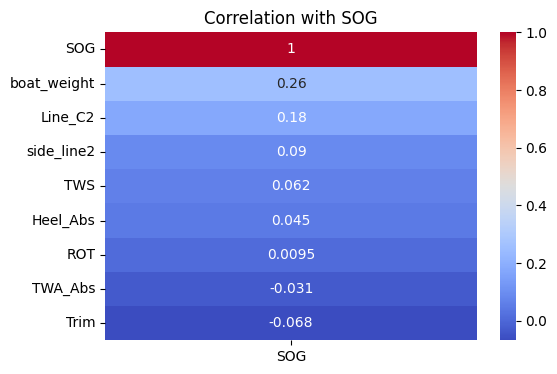


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
boat_weight,3939.589611,1.0,3528.594484,0.000000e+00,0.068904
Trim,788.543418,1.0,706.279138,1.730711e-154,0.014596
Line_C2,679.459550,1.0,608.575373,1.576104e-133,0.012602
TWS,369.101312,1.0,330.595058,1.265906e-73,0.006886
Heel_Abs,80.468213,1.0,72.073419,2.132165e-17,0.001509
TWA_Abs,44.161496,1.0,39.554376,3.218091e-10,0.000829
side_line2,32.883760,1.0,29.453184,5.756243e-08,0.000617
ROT,12.325459,1.0,11.039613,8.925253e-04,0.000231
Residual,53235.789128,47682.0,NaN,NaN,0.500000



Polynomial fit:
R²: 0.107

Top coefficients:
    feature  coefficient
boat_weight     0.072216
        TWS     0.071696
       Trim    -0.042969
    Line_C2     0.010516
 side_line2     0.007883
   Heel_Abs     0.007602
    TWA_Abs     0.005485
        ROT     0.000818


,feature,coefficient
5,boat_weight,0.072216
4,TWS,0.071696
2,Trim,-0.042969
6,Line_C2,0.010516
7,side_line2,0.007883
0,Heel_Abs,0.007602
3,TWA_Abs,0.005485
1,ROT,0.000818


In [5]:
full_analysis(df_numeric_upwind, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

### II.2. Upwind: Gian vs Karl
#### II.2.1. Upwind: Gian

In [6]:
gian_data_upwind = upwind_data[
    (upwind_data['boat_name'] == "Gian Stragiotti") |
    ((upwind_data['boat_name'] == "SenseBoard") & (upwind_data['opponent_name'] == "Karl Maeder"))
]
df_numeric_gian_upwind = gian_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_gian_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_gian_upwind.columns], inplace=True)
df_numeric_gian_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_gian_upwind)}")

Number of rows after filtering: 24390



Initial features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Selected features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Data cleaning:
- Initial samples: 24390
- Removed samples with NaNs: 187
- Final samples: 24203

Correlation with SOG:


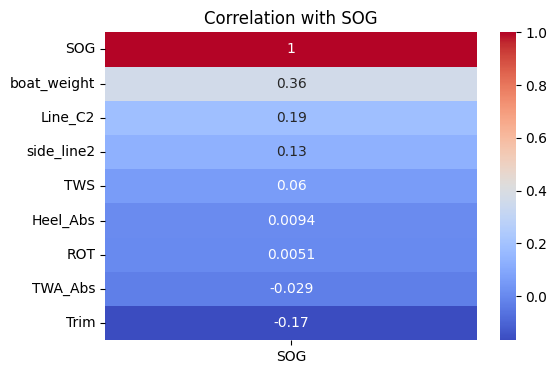


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
boat_weight,3982.811352,1.0,3802.511675,0.000000e+00,0.135821
Line_C2,694.893656,1.0,663.436203,2.359134e-144,0.026690
Trim,576.113556,1.0,550.033212,2.723205e-120,0.022229
TWS,91.118478,1.0,86.993594,1.179172e-20,0.003583
side_line2,73.877020,1.0,70.532648,4.772349e-17,0.002907
TWA_Abs,53.462604,1.0,51.042381,9.295317e-13,0.002105
ROT,3.545445,1.0,3.384945,6.580661e-02,0.000140
Heel_Abs,1.085169,1.0,1.036044,3.087534e-01,0.000043
Residual,25341.181329,24194.0,NaN,NaN,0.500000



Polynomial fit:
R²: 0.200

Top coefficients:
    feature  coefficient
boat_weight     0.174817
       Trim    -0.054018
        TWS     0.051637
 side_line2     0.015887
    Line_C2     0.015270
    TWA_Abs     0.008290
   Heel_Abs     0.001261
        ROT     0.000604


,feature,coefficient
5,boat_weight,0.174817
2,Trim,-0.054018
4,TWS,0.051637
7,side_line2,0.015887
6,Line_C2,0.015270
3,TWA_Abs,0.008290
0,Heel_Abs,0.001261
1,ROT,0.000604


In [7]:
full_analysis(df_numeric_gian_upwind, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

#### II.2.2. Upwind: Karl

In [8]:
karl_data_upwind = upwind_data[
    (upwind_data['boat_name'] == "Karl Maeder") |
    ((upwind_data['boat_name'] == "SenseBoard") & (upwind_data['opponent_name'] == "Gian Stragiotti"))
]
df_numeric_karl_upwind = karl_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_karl_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_karl_upwind.columns], inplace=True)
df_numeric_karl_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_karl_upwind)}")

Number of rows after filtering: 24397


In [9]:
karl_data_upwind.sample(10)

,ISODateTimeUTC,SecondsSince1970,Heel_Abs,Heel_Lwd,Lat,LatBow,LatCenter,LatStern,Leg,Line_C,...,interval_duration,mast_brand,gain_forward,gain_lateral,gain_vmg,Line_R2,Line_L2,Line_C2,side_line2,total_line2
883,2025-06-06T13:48:15.861Z,1.749218e+09,56.2,56.2,43.526440,43.526439,43.526443,43.526447,1.0,93.100,...,83.593,Levi,-1.883125,1.741266,-0.137268,1.700,6.858,93.100,8.558,101.658
33055,2025-06-07T13:00:22.352Z,1.749301e+09,59.5,59.5,43.518683,43.518682,43.518687,43.518692,1.0,9.700,...,67.804,Levi,4.365356,-2.027523,2.211016,9.700,12.700,130.900,22.400,153.300
31745,2025-06-07T12:47:02.857Z,1.749300e+09,51.6,51.6,43.518612,43.518610,43.518614,43.518618,1.0,7.617,...,57.489,Levi,6.105389,1.445704,4.424725,7.617,7.700,125.800,15.317,141.117
66568,2025-06-10T12:53:34.657Z,1.749560e+09,62.0,62.0,43.531662,43.531660,43.531665,43.531671,NaN,119.343,...,51.991,Levi,18.464195,-9.446740,2.711920,5.570,10.800,119.343,16.370,135.713
7073,2025-06-06T14:11:47.860Z,1.749219e+09,58.4,58.4,43.525410,43.525409,43.525413,43.525417,1.0,99.500,...,82.690,Levi,-13.748574,-0.010302,-9.542827,4.200,5.800,99.500,10.000,109.500
47565,2025-06-09T12:54:59.558Z,1.749474e+09,55.3,55.3,43.503020,43.503018,43.503024,43.503030,NaN,110.400,...,68.880,Levi,2.262872,-16.430743,-11.012809,5.300,5.712,110.400,11.012,121.412
28271,2025-06-07T12:26:48.056Z,1.749299e+09,50.8,50.8,43.519240,43.519239,43.519243,43.519248,1.0,6.000,...,55.797,Levi,3.687009,0.124523,2.607548,5.100,6.000,129.200,11.100,140.300
64253,2025-06-10T12:44:37.351Z,1.749559e+09,55.8,55.8,43.533145,43.533143,43.533149,43.533155,NaN,112.800,...,69.201,Levi,0.254898,-3.122493,-2.319163,6.200,6.900,112.800,13.100,125.900
3772,2025-06-06T14:00:17.161Z,1.749218e+09,67.2,67.2,43.526485,43.526484,43.526487,43.526489,1.0,105.200,...,82.987,Levi,1.754395,-4.408859,-3.896529,105.200,NaN,NaN,NaN,NaN
62013,2025-06-10T12:37:22.260Z,1.749559e+09,54.8,54.8,43.531146,43.531145,43.531151,43.531157,NaN,97.459,...,62.101,Levi,13.571201,4.707238,12.422643,4.400,5.595,97.459,9.995,107.454



Initial features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Selected features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Data cleaning:
- Initial samples: 24397
- Removed samples with NaNs: 909
- Final samples: 23488

Correlation with SOG:


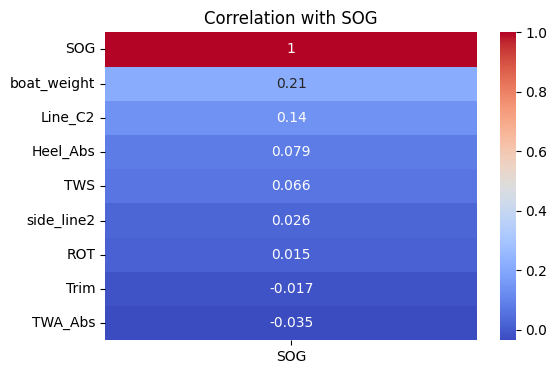


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
boat_weight,1637.487277,1.0,1551.848054,0.000000e+00,0.061997
TWS,377.876229,1.0,358.113616,2.822963e-79,0.015023
Heel_Abs,313.399474,1.0,297.008942,3.772927e-66,0.012492
Line_C2,273.544418,1.0,259.238273,5.145640e-58,0.010921
side_line2,81.862152,1.0,77.580830,1.360364e-18,0.003293
Trim,56.736745,1.0,53.769460,2.327513e-13,0.002285
TWA_Abs,33.710710,1.0,31.947668,1.602190e-08,0.001359
ROT,10.067116,1.0,9.540614,2.012091e-03,0.000406
Residual,24774.696003,23479.0,NaN,NaN,0.500000



Polynomial fit:
R²: 0.089

Top coefficients:
    feature  coefficient
boat_weight     0.139930
        TWS     0.107653
   Heel_Abs     0.021398
 side_line2    -0.018910
       Trim    -0.016126
    Line_C2     0.009639
    TWA_Abs     0.007061
        ROT     0.001077


,feature,coefficient
5,boat_weight,0.139930
4,TWS,0.107653
0,Heel_Abs,0.021398
7,side_line2,-0.018910
2,Trim,-0.016126
6,Line_C2,0.009639
3,TWA_Abs,0.007061
1,ROT,0.001077


In [10]:
full_analysis(df_numeric_karl_upwind, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

#### II.2.3. Upwind: Karl vs Gian t_test

In [11]:
t_test(df_numeric_gian_upwind,df_numeric_karl_upwind)

T-statistic: 31.779, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.


### II.3. Upwind: Master vs Slave
#### II.3.1. Master

In [12]:
master_data_upwind = upwind_data[upwind_data['boat_role'] == "master"]
df_numeric_master_upwind = master_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_master_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_master_upwind.columns], inplace=True)
df_numeric_master_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_master_upwind)}")

Number of rows after filtering: 24391



Initial features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Selected features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Data cleaning:
- Initial samples: 24391
- Removed samples with NaNs: 145
- Final samples: 24246

Correlation with SOG:


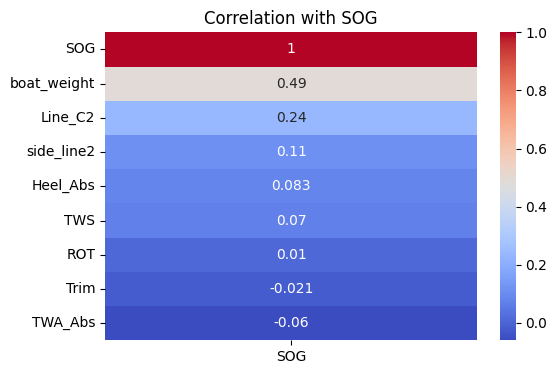


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
boat_weight,7741.203858,1.0,7772.699335,0.000000e+00,0.242823
Line_C2,425.726922,1.0,427.459014,3.773639e-94,0.017331
Trim,288.385725,1.0,289.559037,1.471780e-64,0.011806
TWA_Abs,284.840202,1.0,285.999089,8.598868e-64,0.011662
Heel_Abs,105.430293,1.0,105.859241,8.902666e-25,0.004349
TWS,7.101865,1.0,7.130759,7.582320e-03,0.000294
ROT,0.871264,1.0,0.874809,3.496368e-01,0.000036
side_line2,0.441852,1.0,0.443650,5.053724e-01,0.000018
Residual,24138.790119,24237.0,NaN,NaN,0.500000



Polynomial fit:
R²: 0.290

Top coefficients:
    feature  coefficient
boat_weight     0.144497
       Trim    -0.036163
    TWA_Abs    -0.019361
        TWS     0.014072
   Heel_Abs     0.012029
    Line_C2     0.011619
 side_line2     0.001280
        ROT    -0.000310


,feature,coefficient
5,boat_weight,0.144497
2,Trim,-0.036163
3,TWA_Abs,-0.019361
4,TWS,0.014072
0,Heel_Abs,0.012029
6,Line_C2,0.011619
7,side_line2,0.001280
1,ROT,-0.000310


In [13]:
full_analysis(df_numeric_master_upwind, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

#### II.3.2 Slave

In [14]:
slave_data_upwind = upwind_data[upwind_data['boat_role'] == "slave"]
df_numeric_slave_upwind = slave_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_slave_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_slave_upwind.columns], inplace=True)
df_numeric_slave_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_slave_upwind)}")

Number of rows after filtering: 24396



Initial features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Selected features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Data cleaning:
- Initial samples: 24396
- Removed samples with NaNs: 951
- Final samples: 23445

Correlation with SOG:


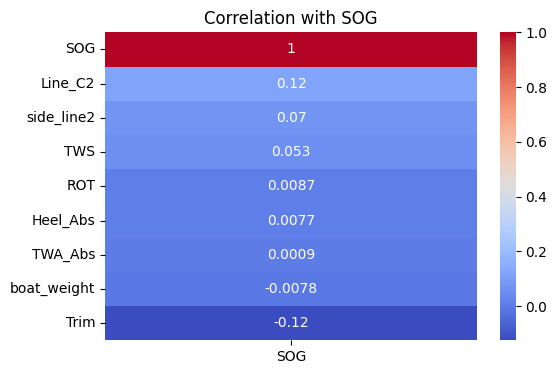


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
Trim,404.880605,1.0,385.275041,4.268622e-85,0.016174
Line_C2,174.903794,1.0,166.434415,5.987297e-38,0.007052
TWS,120.142556,1.0,114.324884,1.274162e-26,0.004854
side_line2,57.468675,1.0,54.685865,1.461656e-13,0.002328
TWA_Abs,40.524056,1.0,38.561757,5.393934e-10,0.001643
boat_weight,10.895262,1.0,10.367680,1.284153e-03,0.000442
ROT,6.962664,1.0,6.625510,1.005892e-02,0.000283
Heel_Abs,1.566851,1.0,1.490979,2.220769e-01,0.000064
Residual,24628.592180,23436.0,NaN,NaN,0.500000



Polynomial fit:
R²: 0.036

Top coefficients:
    feature  coefficient
        TWS     0.059388
       Trim    -0.044377
 side_line2     0.014900
    TWA_Abs     0.008068
    Line_C2     0.007688
boat_weight     0.005689
   Heel_Abs    -0.001553
        ROT     0.000864


,feature,coefficient
4,TWS,0.059388
2,Trim,-0.044377
7,side_line2,0.014900
3,TWA_Abs,0.008068
6,Line_C2,0.007688
5,boat_weight,0.005689
0,Heel_Abs,-0.001553
1,ROT,0.000864


In [15]:
full_analysis(df_numeric_slave_upwind, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

#### III.3.3. Upwind: Master vs Slave t_test

In [16]:
t_test(df_numeric_master_upwind,df_numeric_slave_upwind)

T-statistic: 16.509, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.


## III Downwind
### III.1. All downwind data

In [17]:
downwind_data = df[df['TWA'] < 0]
df_numeric_downwind = downwind_data.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_downwind.columns], inplace=True)
df_numeric_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_downwind)}")

Number of rows after filtering: 31344



Initial features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Selected features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Data cleaning:
- Initial samples: 31344
- Removed samples with NaNs: 1502
- Final samples: 29842

Correlation with SOG:


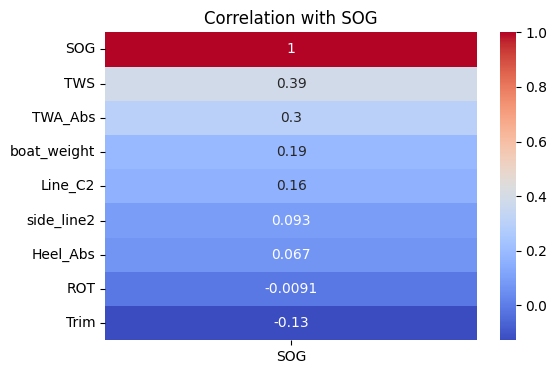


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
TWS,4043.891299,1.0,3653.387561,0.000000e+00,0.109101
boat_weight,1687.324346,1.0,1524.385628,0.000000e+00,0.048613
TWA_Abs,1528.673825,1.0,1381.055405,1.525315e-295,0.044245
Heel_Abs,639.121723,1.0,577.404084,2.191932e-126,0.018987
Line_C2,592.770728,1.0,535.529035,1.920289e-117,0.017634
Trim,497.074579,1.0,449.073912,6.159711e-99,0.014830
ROT,36.875671,1.0,33.314723,7.916246e-09,0.001115
side_line2,19.511676,1.0,17.627505,2.694526e-05,0.000591
Residual,33021.793370,29833.0,NaN,NaN,0.500000



Polynomial fit:
R²: 0.295

Top coefficients:
    feature  coefficient
        TWS     0.325121
boat_weight     0.061438
       Trim    -0.047073
    TWA_Abs     0.030191
   Heel_Abs     0.027921
    Line_C2     0.016387
 side_line2    -0.009128
        ROT    -0.002268


,feature,coefficient
4,TWS,0.325121
5,boat_weight,0.061438
2,Trim,-0.047073
3,TWA_Abs,0.030191
0,Heel_Abs,0.027921
6,Line_C2,0.016387
7,side_line2,-0.009128
1,ROT,-0.002268


In [18]:

full_analysis(df_numeric_downwind, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

### III.2. Downwind: Gian vs Karl
#### III.2.1. Downwind: Gian

In [19]:
gian_data_downwind = downwind_data[
    (downwind_data['boat_name'] == "Gian Stragiotti") |
    ((downwind_data['boat_name'] == "SenseBoard") & (downwind_data['opponent_name'] == "Karl Maeder"))
]
df_numeric_gian_downwind = gian_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_gian_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_gian_downwind.columns], inplace=True)
df_numeric_gian_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_gian_downwind)}")

Number of rows after filtering: 15667



Initial features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Selected features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Data cleaning:
- Initial samples: 15667
- Removed samples with NaNs: 127
- Final samples: 15540

Correlation with SOG:


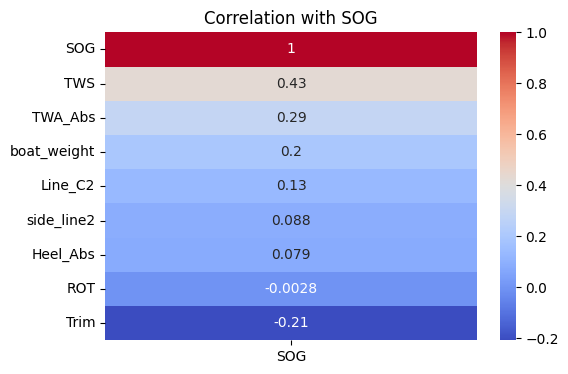


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
TWS,3582.984418,1.0,3229.626993,0.000000e+00,0.172149
TWA_Abs,852.355194,1.0,768.295092,4.277526e-165,0.047137
Heel_Abs,539.906243,1.0,486.660161,3.229292e-106,0.030383
Trim,523.831961,1.0,472.171141,3.693913e-103,0.029505
boat_weight,350.828734,1.0,316.229661,4.745546e-70,0.019955
Line_C2,221.314087,1.0,199.487875,5.130921e-45,0.012682
side_line2,52.628937,1.0,47.438620,5.893170e-12,0.003045
ROT,3.692181,1.0,3.328054,6.812661e-02,0.000214
Residual,17230.265637,15531.0,NaN,NaN,0.500000



Polynomial fit:
R²: 0.351

Top coefficients:
    feature  coefficient
        TWS     0.409190
       Trim    -0.074216
boat_weight     0.059520
   Heel_Abs     0.034706
    TWA_Abs     0.030707
 side_line2     0.019896
    Line_C2     0.014749
        ROT    -0.001016


,feature,coefficient
4,TWS,0.409190
2,Trim,-0.074216
5,boat_weight,0.059520
0,Heel_Abs,0.034706
3,TWA_Abs,0.030707
7,side_line2,0.019896
6,Line_C2,0.014749
1,ROT,-0.001016


In [20]:

full_analysis(df_numeric_gian_downwind, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

#### III.2.2. Downwind: Karl

In [21]:
karl_data_downwind = downwind_data[
    (downwind_data['boat_name'] == "Karl Maeder") |
    ((downwind_data['boat_name'] == "SenseBoard") & (downwind_data['opponent_name'] == "Gian Stragiotti"))
]
df_numeric_karl_downwind = karl_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_karl_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_karl_downwind.columns], inplace=True)
df_numeric_karl_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_karl_downwind)}")

Number of rows after filtering: 15677



Initial features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Selected features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Data cleaning:
- Initial samples: 15677
- Removed samples with NaNs: 1375
- Final samples: 14302

Correlation with SOG:


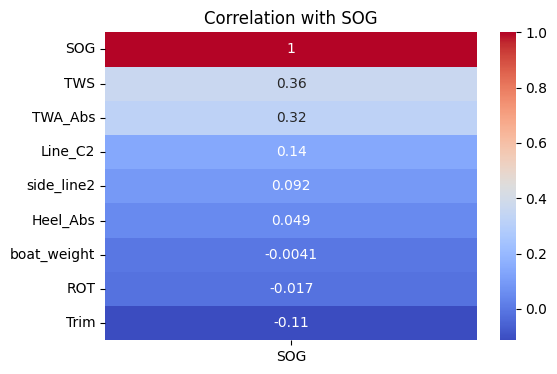


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
TWS,1064.638259,1.0,1024.370225,3.816730e-217,0.066876
TWA_Abs,868.127348,1.0,835.291988,1.491607e-178,0.055214
Line_C2,370.794379,1.0,356.769746,1.286509e-78,0.024353
boat_weight,310.640819,1.0,298.891387,2.710790e-66,0.020483
side_line2,214.184951,1.0,206.083789,2.065194e-46,0.014214
Heel_Abs,153.869080,1.0,148.049258,6.806954e-34,0.010252
Trim,52.358125,1.0,50.377773,1.327967e-12,0.003512
ROT,18.572203,1.0,17.869743,2.380219e-05,0.001249
Residual,14854.858388,14293.0,NaN,NaN,0.500000



Polynomial fit:
R²: 0.229

Top coefficients:
    feature  coefficient
        TWS     0.269584
boat_weight     0.086645
 side_line2    -0.048795
    TWA_Abs     0.034574
       Trim    -0.021268
   Heel_Abs     0.020587
    Line_C2     0.018443
        ROT    -0.002289


,feature,coefficient
4,TWS,0.269584
5,boat_weight,0.086645
7,side_line2,-0.048795
3,TWA_Abs,0.034574
2,Trim,-0.021268
0,Heel_Abs,0.020587
6,Line_C2,0.018443
1,ROT,-0.002289


In [22]:
full_analysis(df_numeric_karl_downwind, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

#### III.2.3. Downwind: Karl vs Gian t_test

In [23]:
t_test(df_numeric_karl_downwind,df_numeric_gian_downwind)

T-statistic: -38.976, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.


### III.3. Downwind: Master vs Slave
#### III.3.1 Downwind Master

In [24]:
master_data_downwind = downwind_data[downwind_data['boat_role'] == "master"]
df_numeric_master_downwind = master_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_master_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_master_downwind.columns], inplace=True)
df_numeric_master_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_master_downwind)}")

Number of rows after filtering: 15670



Initial features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Selected features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Data cleaning:
- Initial samples: 15670
- Removed samples with NaNs: 90
- Final samples: 15580

Correlation with SOG:


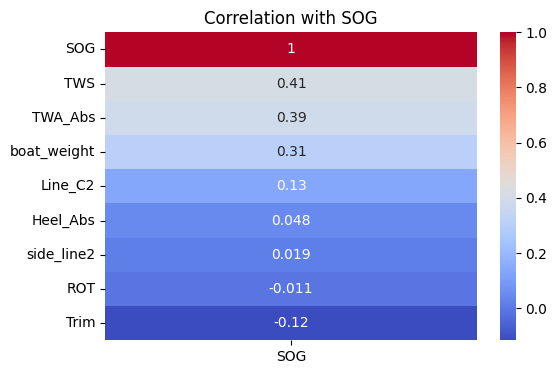


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
TWS,2102.230556,1.0,1953.611916,0.000000e+00,0.111478
boat_weight,1978.151302,1.0,1838.304530,0.000000e+00,0.105593
TWA_Abs,1826.175726,1.0,1697.072973,0.000000e+00,0.098278
Heel_Abs,521.092715,1.0,484.253705,1.029922e-105,0.030162
Trim,392.458251,1.0,364.713144,2.195883e-80,0.022887
Line_C2,269.839149,1.0,250.762684,4.846670e-56,0.015849
side_line2,208.783981,1.0,194.023853,7.710331e-44,0.012307
ROT,29.541857,1.0,27.453375,1.630261e-07,0.001760
Residual,16755.544807,15571.0,NaN,NaN,0.500000



Polynomial fit:
R²: 0.390

Top coefficients:
    feature  coefficient
        TWS     0.313660
boat_weight     0.093426
       Trim    -0.057471
    TWA_Abs     0.042099
 side_line2    -0.041337
   Heel_Abs     0.034249
    Line_C2     0.015555
        ROT    -0.002827


,feature,coefficient
4,TWS,0.313660
5,boat_weight,0.093426
2,Trim,-0.057471
3,TWA_Abs,0.042099
7,side_line2,-0.041337
0,Heel_Abs,0.034249
6,Line_C2,0.015555
1,ROT,-0.002827


In [25]:
full_analysis(df_numeric_master_downwind, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

#### III.3.2 Downwind Slave

In [26]:
slave_data_downwind = downwind_data[downwind_data['boat_role'] == "slave"]
df_numeric_slave_downwind = slave_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_slave_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_slave_downwind.columns], inplace=True)
df_numeric_slave_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_slave_downwind)}")

Number of rows after filtering: 15674



Initial features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Selected features (8): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2']

Data cleaning:
- Initial samples: 15674
- Removed samples with NaNs: 1412
- Final samples: 14262

Correlation with SOG:


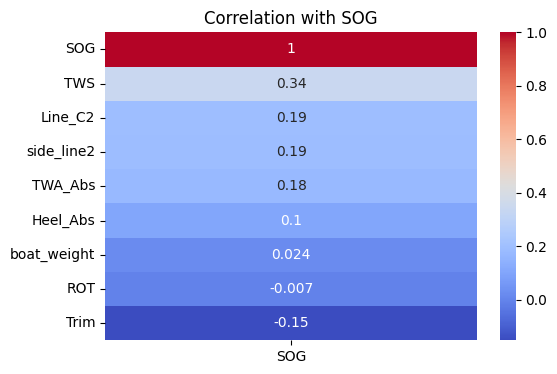


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
TWS,1945.605151,1.0,1899.914449,0.000000e+00,0.117621
Trim,225.921697,1.0,220.616139,1.557022e-49,0.015243
Heel_Abs,203.891496,1.0,199.103297,6.572256e-45,0.013777
boat_weight,156.522172,1.0,152.846397,6.249599e-35,0.010610
side_line2,128.388202,1.0,125.373126,5.571159e-29,0.008720
Line_C2,114.354089,1.0,111.668591,5.270201e-26,0.007774
TWA_Abs,57.223908,1.0,55.880058,8.151306e-14,0.003905
ROT,6.322247,1.0,6.173775,1.297715e-02,0.000433
Residual,14595.767843,14253.0,NaN,NaN,0.500000



Polynomial fit:
R²: 0.232

Top coefficients:
    feature  coefficient
        TWS     0.346702
       Trim    -0.046876
 side_line2     0.034162
boat_weight     0.027171
   Heel_Abs     0.023444
    Line_C2     0.010455
    TWA_Abs     0.009488
        ROT    -0.001350


,feature,coefficient
4,TWS,0.346702
2,Trim,-0.046876
7,side_line2,0.034162
5,boat_weight,0.027171
0,Heel_Abs,0.023444
6,Line_C2,0.010455
3,TWA_Abs,0.009488
1,ROT,-0.001350


In [27]:
full_analysis(df_numeric_slave_downwind, target_variable="SOG", max_null_ratio=MAX_NULL_RATIO)

#### III.3.3. Downwind: Master vs Slave t_test

In [28]:
t_test(df_numeric_master_downwind,df_numeric_slave_downwind)

T-statistic: 0.953, p-value: 0.340575073568009
The difference is not statistically significant, keeping data combined.
